# AML HW 1 - OU1G79
Made by: Bodai Adrián Tibor

In [83]:
# Imports
import numpy as np
import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split
from scipy.stats import multivariate_normal
from collections import Counter
from matplotlib import pyplot as plt
from scipy.spatial.distance import cdist

## Loading the data

In [70]:
# Loading the data and showing it

# I downloaded and extracted the tar data into my local folder
df = pd.read_csv('C:/Adrian/Egyetem-Msc/3. félév/Advanced Machine Learning/PetersonBarney/verified_pb.data', delim_whitespace=True, header=None)
df

,0,1,2,3,4,5,6,7
0,1,1,1,IY,160.0,240.0,2280.0,2850.0
1,1,1,1,IY,186.0,280.0,2400.0,2790.0
2,1,1,2,IH,203.0,390.0,2030.0,2640.0
3,1,1,2,IH,192.0,310.0,1980.0,2550.0
4,1,1,3,EH,161.0,490.0,1870.0,2420.0
...,...,...,...,...,...,...,...,...
1515,3,76,8,UH,322.0,610.0,1550.0,3400.0
1516,3,76,9,UW,345.0,520.0,1250.0,3460.0
1517,3,76,9,UW,334.0,500.0,1140.0,3380.0
1518,3,76,10,ER,308.0,740.0,1850.0,2160.0


Formatting the data based on the HEADER file

M/F/C	SPKR	Phoneme-Number	Phoneme-Ascii	F0	F1	F2	F3

1 - M	1-33

2 - F	34-61

3 - C	62-76

In [71]:
df.columns = ['Gender', 'SPKR', 'PhonemeNumber', 'Phoneme-Ascii', 'F0', 'F1', 'F2', 'F3']

# Asterisk in ARPABET phoneme field means utterance failed of unanimous identification
df = df[~df['Phoneme-Ascii'].str.contains('\*')].reset_index(drop=True)
phen_mapper = {'AA': 0, 'AE': 1, 'AH': 2, 'AO': 3, 'EH': 4, 'ER': 5, 'IH': 6, 'IY': 7, 'UH': 8, 'UW': 9}
df['Phoneme-Num'] = [phen_mapper[x] for x in df['Phoneme-Ascii']]
df

,Gender,SPKR,PhonemeNumber,Phoneme-Ascii,F0,F1,F2,F3,Phoneme-Num
0,1,1,1,IY,160.0,240.0,2280.0,2850.0,7
1,1,1,1,IY,186.0,280.0,2400.0,2790.0,7
2,1,1,2,IH,203.0,390.0,2030.0,2640.0,6
3,1,1,2,IH,192.0,310.0,1980.0,2550.0,6
4,1,1,3,EH,161.0,490.0,1870.0,2420.0,4
...,...,...,...,...,...,...,...,...,...
1194,3,76,8,UH,322.0,610.0,1550.0,3400.0,8
1195,3,76,9,UW,345.0,520.0,1250.0,3460.0,9
1196,3,76,9,UW,334.0,500.0,1140.0,3380.0,9
1197,3,76,10,ER,308.0,740.0,1850.0,2160.0,5


In [72]:
# Creating the training X and Y set, and the validation data set

X_df = df[['F0', 'F1', 'F2', 'F3']]
y_df = df['Phoneme-Num']

# I did not create a test set and a validation dataset seperately, because the problem is already solvable with 1 type of validation / test dataset
# I could separate the validation dataset into test and val dataset, but this would not change anything regarding the progam and every evaluation would stay the same
# The code would be: 

X_train, X_val_test, y_train, y_val_test = train_test_split(X_df, y_df, test_size=0.2, random_state=42) # 80% - 20%
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.5, random_state=42) # 10% - 10%

# X_train, X_val, y_train, y_val = train_test_split(X_df, y_df, test_size=0.2, random_state=42)
print(f'Train data: {len(X_train)}\nValidation data: {len(X_val)}\nTest data: {len(X_val)}')

Train data: 959
Validation data: 120
Test data: 120


In [73]:
X_train

,F0,F1,F2,F3
331,135.0,350.0,2240.0,2760.0
409,125.0,688.0,1600.0,2300.0
76,135.0,750.0,1690.0,2320.0
867,224.0,896.0,2040.0,3000.0
138,143.0,600.0,860.0,2175.0
...,...,...,...,...
1044,214.0,640.0,1070.0,3000.0
1095,244.0,403.0,1100.0,2950.0
1130,295.0,380.0,3200.0,4000.0
860,201.0,400.0,1240.0,1480.0


In [74]:
y_train

331     7
409     1
76      1
867     1
138     3
       ..
1044    3
1095    9
1130    7
860     5
1126    9
Name: Phoneme-Num, Length: 959, dtype: int64

## Part 0: A baseline "not as strong" model

Basically, what was described on the lecture, this model should be a 1NN classifier on the centroids of the clusters

In [82]:
centroids = X_train.groupby(y_train).mean()
centroids

,F0,F1,F2,F3
Phoneme-Num,,,,
0,183.803030,851.909091,1204.666667,2701.318182
1,182.373737,839.636364,1948.444444,2772.979798
2,201.670732,739.731707,1402.414634,2793.292683
3,184.858824,584.717647,881.400000,2662.576471
4,185.714286,581.885714,2189.385714,2857.100000
5,190.196721,513.327869,1538.860656,1888.557377
6,192.505155,429.216495,2296.927835,2895.773196
7,201.890909,301.672727,2658.636364,3235.136364
8,201.245455,470.263636,1152.763636,2633.572727


In [102]:
mean_centroids = X_train.groupby(y_train).mean().values

def compute_distances(data, centroids):
    return cdist(data, centroids, metric='euclidean')
def predict_labels(distance_matrix):
    return np.argmin(distance_matrix, axis=1)
def evaluate_accuracy(y_true, y_pred):
    return sklearn.metrics.accuracy_score(y_true, y_pred)

# predicting with the baseline model
train_distances = compute_distances(X_train.values, mean_centroids)
val_distances = compute_distances(X_val.values, mean_centroids)
test_distances = compute_distances(X_test.values, mean_centroids)

y_pred_train = predict_labels(train_distances)
y_pred_val = predict_labels(val_distances)
y_pred_test = predict_labels(test_distances)

# Printing thew outcome and calculating the accuracy
train_accuracy = evaluate_accuracy(y_train, y_pred_train)
print(f"Training accuracy: {train_accuracy}")

val_accuracy = evaluate_accuracy(y_val, y_pred_val)
print(f"Validation accuracy: {val_accuracy}")

test_accuracy = evaluate_accuracy(y_test, y_pred_test)
print(f"Test accuracy: {test_accuracy}")

Training accuracy: 0.5610010427528676
Validation accuracy: 0.5416666666666666
Test accuracy: 0.5083333333333333


These accuracies are really bad, compared to the complexity of the dataset

## Part 1: Baseline model 2 - KNN Classifier
This is one of the weakest classifiers for a datasert which I could think of. It will work well based on the looks of the dataset, beacuse the data is somewhat dense, but other, more advanced classifiers may work much much better than this simple method

In [75]:
# Define a KNN prediction function, I could use some pre made methods, but I wanted to create my own

def euclidean_distance(x1, x2):
    return np.sqrt(np.sum((x1 - x2) ** 2))

# KNN classifier function, "trains" and predicts for the val dataset based on the train dataset X-s and labels
def knn_predict(X_train, y_train, X_test, k=3):
    y_pred = []
    for i in range(len(X_test)):
        distances = []
        for j in range(len(X_train)):
            dist = euclidean_distance(X_test.iloc[i].values, X_train.iloc[j].values)
            distances.append((dist, y_train.iloc[j]))

        distances.sort(key=lambda x: x[0])
        k_nearest_neighbors = distances[:k]
        
        # Get the labels of the K nearest neighbors and predict the majority in the class
        k_nearest_labels = [label for _, label in k_nearest_neighbors]
        most_common = Counter(k_nearest_labels).most_common(1)[0][0]
        y_pred.append(most_common)
    
    return np.array(y_pred)

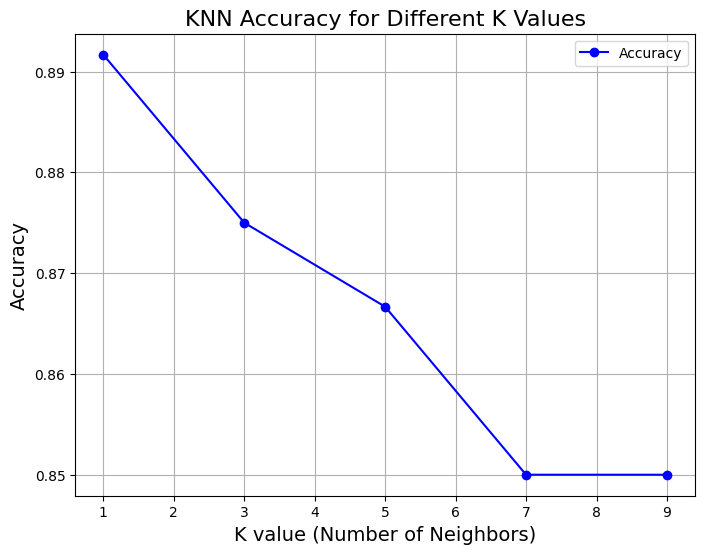

In [76]:
# Try the model for different values of K
accuracy_scores = {}
for k in range(1, 11, 2):
    y_pred_knn = knn_predict(X_train, y_train, X_val, k=k)
    accuracy_knn = sklearn.metrics.accuracy_score(y_val, y_pred_knn)
    # print(f"Accuracy for K={k}: {accuracy_knn}")
    accuracy_scores[k] = accuracy_knn

k_values = list(accuracy_scores.keys())
accuracies = list(accuracy_scores.values())

# Creating a plot which is good for showing the accuracy scores
plt.figure(figsize=(8, 6))
plt.plot(k_values, accuracies, marker='o', linestyle='-', color='b', label='Accuracy')

plt.xlabel('K value (Number of Neighbors)', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.title('KNN Accuracy for Different K Values', fontsize=16)
plt.grid(True)

plt.legend()
plt.show()

In [77]:
# It can be seen, that the best possible KNN classifier is with K == 1, which has a big variance, but on this dataset, this is the best
# Evaluation on the test data, after we used the val data to have the k
y_pred_knn = knn_predict(X_train, y_train, X_test, k=1)
accuracy_knn = sklearn.metrics.accuracy_score(y_test, y_pred_knn)
print(f"Accuracy for K=1: {accuracy_knn}")

Accuracy for K=1: 0.8833333333333333


## Part 2: Advanced model - Gaussian mixture model

In [78]:
# Ceating the centroids
centroids = X_train.groupby(y_train).mean()
centroids

,F0,F1,F2,F3
Phoneme-Num,,,,
0,183.803030,851.909091,1204.666667,2701.318182
1,182.373737,839.636364,1948.444444,2772.979798
2,201.670732,739.731707,1402.414634,2793.292683
3,184.858824,584.717647,881.400000,2662.576471
4,185.714286,581.885714,2189.385714,2857.100000
5,190.196721,513.327869,1538.860656,1888.557377
6,192.505155,429.216495,2296.927835,2895.773196
7,201.890909,301.672727,2658.636364,3235.136364
8,201.245455,470.263636,1152.763636,2633.572727


In [79]:
# Creating the covariuance matrices for the data
unique_classes = np.unique(y_train)
cov_matrices = {}

for cls in unique_classes:
    X_class = X_train[y_train == cls]
    cov_matrix = np.cov(X_class.T)
    cov_matrices[cls] = cov_matrix
cov_matrices[0]

array([[  2949.32983683,   6322.81258741,   4777.17948718,
         12787.69440559],
       [  6322.81258741,  19817.34545455,  15012.04615385,
         35480.3986014 ],
       [  4777.17948718,  15012.04615385,  17496.59487179,
         26369.09230769],
       [ 12787.69440559,  35480.3986014 ,  26369.09230769,
        144990.92797203]])

In [80]:
# Creating functions which can be used for evaluation

def predict_proba(x, centroids, cov_matrices):
    # This function gives one prediction for a single data point with probabilites
    probs = {}
    for cls in centroids.index:
        mean = centroids.loc[cls].values
        cov = cov_matrices[cls]
        prob = multivariate_normal(mean=mean, cov=cov).pdf(x)
        probs[cls] = prob
    
    return probs

def predict(X_new, centroids, cov_matrices):
    # Get the max(1) prediction from the probablities for all data points in the data set (pandas dataframe)
    y_pred = []
    for i in range(len(X_new)):
        x = X_new.iloc[i].values
        probs = predict_proba(x, centroids, cov_matrices)
        y_pred.append(max(probs, key=probs.get))
    
    return np.array(y_pred)

In [81]:
# Making the predictions for both train and val dataset
y_pred_train = predict(X_train, centroids, cov_matrices)


# Here it does not really matter that we have validation and test data set, we didnt really have to adjust any parameters based on the validation dataset
y_pred_val = predict(X_val, centroids, cov_matrices)
y_pred_test = predict(X_test, centroids, cov_matrices)


accuracy_train = sklearn.metrics.accuracy_score(y_train, y_pred_train)
print("Train accuracy:", accuracy_train)
accuracy_val = sklearn.metrics.accuracy_score(y_val, y_pred_val)
print("Val accuracy:", accuracy_val)
accuracy_test = sklearn.metrics.accuracy_score(y_test, y_pred_test)
print("Test accuracy:", accuracy_test)

Train accuracy: 0.9249217935349322
Val accuracy: 0.9083333333333333
Test accuracy: 0.8416666666666667
